In [1]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

In [2]:

from utils.jraph_training import train_and_evaluate_with_data, create_dataset, evaluate_model, rollout
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile
import matplotlib.pyplot as plt 
import numpy as np 

import jax
from utils.jraph_training import create_dataset, create_model, create_optimizer
from clu import checkpoint
from clu import parameter_overview
from flax.training import train_state



/Users/miamirabelli/Desktop/GNN Research/lorenzGNN/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import ml_collections

config = ml_collections.ConfigDict()

# Data params. 
config.n_samples=5000
config.input_steps=1
config.output_delay=0 # predict 0 hours into the future
config.output_steps=6
config.timestep_duration=3
config.sample_buffer=-1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
config.time_resolution=120
config.init_buffer_samples=0
config.train_pct=0.7
config.val_pct=0.2
config.test_pct=0.1
config.K=36
config.F=8
config.c=10
config.b=10
config.h=1
config.seed=50
config.normalize=True
config.fully_connected_edges=5

# Optimizer.
config.optimizer = 'sgd'
config.learning_rate = 0.00045346796177033903
config.momentum = 0.8712873602503628

# Training hyperparameters.
# config.batch_size = 3
config.epochs = 150
config.log_every_epochs = 5
config.eval_every_epochs = 5
config.checkpoint_every_epochs = 10
config.max_checkpts_to_keep = None # None means keep all checkpoints

# GNN hyperparameters.
config.model = 'MLPGraphNetwork'
config.n_blocks = 1
config.activation = 'relu'
config.dropout_rate = 0.013287043114620523
config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config.layer_norm = False # TODO perhaps we want to turn on later
config.edge_features = (8, 8) # the last feature size will be the number of features that the graph predicts
config.node_features = (32, 2)
config.global_features = None
config.share_params = False

In [4]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [5]:
from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts
from utils.jraph_training import create_dataset

In [6]:
datasets = create_dataset(config)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [7]:
workdir="tests/outputs/chem_talk_figures10"

trained_state, train_metrics, eval_metrics_dict, _ = train_and_evaluate_with_data(
    config=config, workdir=workdir, datasets=datasets)


INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.013287043114620523, 'edge_features': (8, 8), 'epochs': 150, 'eval_every_epochs': 5, 'fully_connected_edges': 5, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.00045346796177033903, 'log_every_epochs': 5, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'momentum': 0.8712873602503628, 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'sgd', 'output_delay': 0, 'output_steps': 6, 'sample_buffer': -6, 'seed': 50, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size |

whats our best hyperparams?

In [69]:
# for i in range(6):
#     hours = (i+1) * 3 
#     plot_predictions(
#         config=config,
#         workdir=workdir, # for loading checkpoints 
#         plot_ith_rollout_step=i, # 0 indexed # for this study, we have a 6-step rollout 
#         node=0, # 0-indexed 
#         plot_mode="test", # i.e. "train"/"val"/"test"
#         datasets=datasets,
#         plot_days=60,
#         title=" "
#     )

In [33]:
def plot_predictions_multirollout(
    config,
    workdir, # for loading checkpoints 
    node, # 0-indexed 
    plot_mode, # i.e. "train"/"val"/"test"
    datasets=None,
    plot_days=None, # if None, plot entire time series; otherwise plot specified number of days 
    title=''):
    assert plot_mode in ["train", "val", "test"]

    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    assert os.path.exists(checkpoint_dir)

    # samples must be overlapping and consecutive for this plot to really be interpretable the way it is meant 
    assert (
        config.input_steps + config.output_delay + config.output_steps + config.sample_buffer == 1
        )

    # Get datasets, organized by split.
    if datasets is None:
        logging.info('Generating datasets from config because none provided.')
        datasets = create_dataset(config)

    plot_set = datasets[plot_mode]
    input_data = plot_set['inputs']
    target_data = plot_set['targets']
    # n_rollout_steps = config.output_steps

    # Create the evaluation state, corresponding to a deterministic model.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = input_data[0]
    eval_net = create_model(config, deterministic=True)
    params = jax.jit(eval_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer and state.
    # (we don't actually need the optimizer for evaluation, we just need it to create the state)
    tx = create_optimizer(config)
    state = train_state.TrainState.create(
        apply_fn=eval_net.apply, params=params, tx=tx
    )

    # load the checkpoint state
    ckpt = checkpoint.Checkpoint(checkpoint_dir)
    state = ckpt.restore(state) # restore latest checkpoint 

    # get the predictions from the model for the ith step of the rollout and for the specified node
    node_preds_all_rollouts = []
    node_targets = []

    # loop over individual windows in the dataset 
    # TODO try batching to see if its faster? 

    if plot_days is not None:
        plot_count = plot_days * config.time_resolution / 5 / config.timestep_duration
    else:
        plot_count = len(input_data)

    for i, (input_window_graphs, target_window_graphs) in enumerate(zip(
        input_data, target_data)):
        if i >= plot_count:
            break
        pred_nodes_list = rollout(state=state,
                                  input_window_graphs=input_window_graphs,
                                  n_rollout_steps=config.output_steps,
                                #   n_rollout_steps=plot_ith_rollout_step+1, # +1 since plot_ith_rollout_step is 0-indexed
                                  rngs=None) # deterministic during eval
        
        # get the last array of predictions, which will correspond to the ith rollout step that we care about 
        # ith_rollout_pred = pred_nodes_list[plot_ith_rollout_step]
        # node_pred = ith_rollout_pred[node, :] # jnp array with shape (1, 2)
        node_preds_all_rollouts.append([ith_rollout_pred[node, :] for ith_rollout_pred in pred_nodes_list])

        # also grab the target nodes while we're in this loop 
        # ith_rollout_target = target_window_graphs[plot_ith_rollout_step].nodes
        node_target = target_window_graphs[0].nodes[node, :] # jnp array with shape (1, 2)
        node_targets.append(node_target)
        # node_targets.append([ith_rollout_target.nodes[node, :] for ith_rollout_target in target_window_graphs])

    node_preds_all_rollouts = np.array(node_preds_all_rollouts) # shape (len(t_days), output_steps, 2)
    node_targets = np.array(node_targets) # shape (len(t_days), 2)

    # reconstruct timesteps
    steps = np.arange(plot_count)
    # convert timesteps from step index to day 
    t_days = steps * config.timestep_duration * 5 / config.time_resolution 

    # set up plot
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
    if title == '':
        fig.suptitle(f"{plot_mode} predictions for node {node}", size=35)
    else:
        fig.suptitle(title, size=30)
    ax0.set_title("X1 (i.e. oceanic variable) for node {}".format(node),
                  size=25)
    ax1.set_title("X2 (i.e. atmospheric variable) for node {}".format(node),
                  size=25)
    plt.xlabel('time (days)', size=23)

    # plot rollout targets
    ax0.plot(
        t_days,
        node_targets[:, 0],
        # s=5,
        alpha=0.8,
        label='targets',
        c='blue')
    ax1.plot(
        t_days,
        node_targets[:, 1], 
        alpha=0.8, 
        label='targets', 
        c='blue')

    # plot predictions
    labels = ['rollout 0', 'rollout 1', 'rollout 2', 'rollout 3', 'rollout 4', 'rollout 5']
    for i in range(config.output_steps):
        rollout_steps = np.arange(i, plot_count + i)
        t_days_rollout = rollout_steps * config.timestep_duration * 5 / config.time_resolution 
        ax0.plot(
            t_days_rollout,
            node_preds_all_rollouts[:, i, 0],
            # s=5,
            alpha=0.8,
            label=labels[i])
        ax0.tick_params(labelsize=22)
        ax1.plot(
            t_days_rollout,
            node_preds_all_rollouts[:, i, 1],
            # s=5,
            alpha=0.8)
        ax1.tick_params(labelsize=22)

    fig.legend(labels, bbox_to_anchor=(0.99, 0.5), loc="center left", fontsize = 18) # labels, loc='lower center')
    fig.tight_layout()
    fig.show()


INFO:root:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 8)   | 48   | -0.103   | 0.37  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (8, 8)   | 64   | -0.0189  | 0.344 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+------

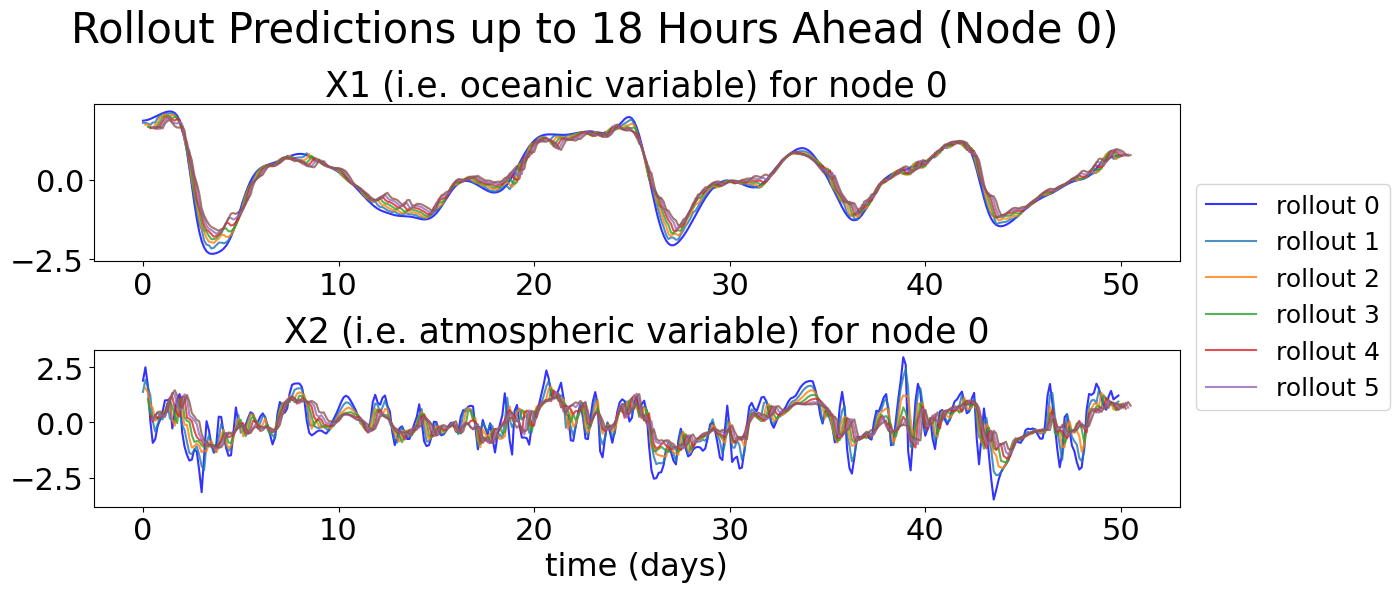

In [34]:
plot_predictions_multirollout(
    config=config,
    workdir=workdir,
    node=0,
    plot_mode='test',
    datasets=datasets,
    plot_days=50,
    title='Rollout Predictions up to 18 Hours Ahead (Node 0)')

In [72]:
def load_model_with_checkpoint(config, workdir, ckpt_path, datasets):
    # Create and initialize the network.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = datasets["train"]["inputs"][0]
    init_net = create_model(config, deterministic=True)
    params = jax.jit(init_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer.
    tx = create_optimizer(config)

    # Create the training state.
    net = create_model(config, deterministic=True) # deterministic because we are doing evaluation, we don't want dropout (that's only for training)
    state = train_state.TrainState.create(
        apply_fn=net.apply, params=params, tx=tx
    )

    # Set up checkpointing of the model.
    # The input pipeline cannot be checkpointed in its current form,
    # due to the use of stateful operations.
    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    ckpt = checkpoint.Checkpoint(checkpoint_dir, 
                                 max_to_keep=config.max_checkpts_to_keep)
    state = ckpt.restore(state=state, checkpoint=ckpt_path)

    return state

In [73]:
ckpt_num = 12
ckpt_path = os.path.join(workdir, f"checkpoints/ckpt-{ckpt_num}")

state = load_model_with_checkpoint(config, workdir, ckpt_path, datasets)

INFO:root:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 8)   | 48   | -0.103   | 0.37  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (8, 8)   | 64   | -0.0189  | 0.344 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+------

In [74]:
# eval_metrics_dict = evaluate_model(
#     state = state,
#     n_rollout_steps = config.output_steps,
#     datasets = datasets,
#     splits = ["val", "test"],
#     all_metrics = True
# )

In [75]:
# print("Mean Squared Error:", eval_metrics_dict["val"].mse.compute())
# print("Mean Bias:", eval_metrics_dict["val"].mb.compute())
# print("Mean Error:", eval_metrics_dict["val"].me.compute())
# print("Root Mean Squared Error:", eval_metrics_dict["val"].rmse.compute())
# print("Centered Root Mean Squared Error:", eval_metrics_dict["val"].crmse.compute())
# print("fractional bias:".title(), eval_metrics_dict["val"].fb.compute())
# print("fractional error:".title(), eval_metrics_dict["val"].fe.compute())
# print("correlation coefficient (R):".title(), eval_metrics_dict["val"].r.compute())
# print("R^2:".title(), eval_metrics_dict["val"].r2.compute())
# print("Index of agreement:".title(), eval_metrics_dict["val"].d.compute())

In [76]:
import os
from typing import Dict, Iterable, List, Optional, Callable
import jraph
import jax.numpy as jnp
from utils.jraph_training import MSE, MB, ME, RMSE, CRMSE, FB, FE, R, R2, D

In [77]:
def rollout_metric_list(
        metric_funcs: Iterable[Callable],
        state: train_state.TrainState, 
        input_window_graphs: Iterable[jraph.GraphsTuple],
        target_window_graphs: Iterable[jraph.GraphsTuple],
        n_rollout_steps: int,
        rngs: Optional[Dict[str, jnp.ndarray]] = None,
    ) -> Dict[str, List[float]]:
    """ Computes a suite of metrics for an n-step rollout. 
    
        Also returns predicted nodes.
    """
    assert n_rollout_steps > 0
    assert len(target_window_graphs) == n_rollout_steps, (len(target_window_graphs), n_rollout_steps)

    curr_input_window_graphs = input_window_graphs
    pred_nodes = []

    # initialize metrics dict 
    metric_totals = {metric.__name__.lower(): [] for metric in metric_funcs}

    for i in range(n_rollout_steps):
        pred_graphs_list = state.apply_fn(state.params, curr_input_window_graphs, rngs=rngs) 
        pred_graph = pred_graphs_list[0]

        # retrieve the new input window 
        curr_input_window_graphs = curr_input_window_graphs[1:] + [pred_graph]

        preds = pred_graph.nodes

        targets = target_window_graphs[i].nodes

        # compute metrics
        for metric in metric_funcs:
            metric_val = metric(targets=targets, preds=preds)
            metric_totals[metric.__name__.lower()].append(metric_val) # adds 
    
        pred_nodes.append(preds)

    return metric_totals

In [78]:
def evaluate_model_rollout(
    state: train_state.TrainState,
    n_rollout_steps: int,
    datasets: Dict[str, Dict[str, Iterable[jraph.GraphsTuple]]], 
    # first key = train/test/val, second key = input/target 
    split: str # e.g. ["val", "test"],
) -> Dict[str, List[float]]:
    """Evaluates the model on metrics over the specified splits (i.e. modes)."""

    # Loop over each split independently.
    eval_metrics_dict = {}
    input_data = datasets[split]['inputs']
    target_data = datasets[split]['targets']

    # Initialize metrics dict
    metric_totals = {metric_name: [[] for _ in range(n_rollout_steps)] for metric_name in 
                     ["mse", "r2"]}

    # Loop over individual windows in the dataset 
    for (input_window_graphs, target_window_graphs) in zip(input_data, target_data):
        split_metrics_update = rollout_metric_list(
            metric_funcs=[MSE, R2],
            state=state, 
            n_rollout_steps=n_rollout_steps, 
            input_window_graphs=input_window_graphs, 
            target_window_graphs=target_window_graphs)

        # Update metrics.
        for metric_name, step_values in split_metrics_update.items():
            for step, values in enumerate(step_values):
                metric_totals[metric_name][step].append(values)

    # Compute averages for each step in the rollout 
    eval_metrics_dict = {metric_name: np.array([np.mean(step_values) for step_values in step_values_list])
                         for metric_name, step_values_list in metric_totals.items()}

    return eval_metrics_dict  # pytype: disable=bad-return-type

In [79]:
def plot_multirollout_metrics(
    config,
    workdir, # for loading checkpoints 
    plot_mode, # i.e. "train"/"val"/"test"
    datasets=None,
    metrics_dict=None,
    title=''):
    assert plot_mode in ["train", "val", "test"]

    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    assert os.path.exists(checkpoint_dir)

    # Get datasets, organized by split.
    if datasets is None:
        logging.info('Generating datasets from config because none provided.')
        datasets = create_dataset(config)

    plot_set = datasets[plot_mode]
    input_data = plot_set['inputs']
    n_rollout_steps = config.output_steps
    rollout_nums = np.arange(n_rollout_steps)

    # Create the evaluation state, corresponding to a deterministic model.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = input_data[0]
    eval_net = create_model(config, deterministic=True)
    params = jax.jit(eval_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer and state.
    # (we don't actually need the optimizer for evaluation, we just need it to create the state)
    tx = create_optimizer(config)
    state = train_state.TrainState.create(
        apply_fn=eval_net.apply, params=params, tx=tx
    )

    # load the checkpoint state
    ckpt = checkpoint.Checkpoint(checkpoint_dir)
    state = ckpt.restore(state) # restore latest checkpoint 

    # gets all metrics
    if metrics_dict is None: 
        logging.info('Generating metrics from dataset because none provided.')
        metrics_dict = evaluate_model_rollout(
            state=state,
            n_rollout_steps=config.output_steps,
            datasets=datasets,
            split=plot_mode)

    # set up plot
    # NOTE: remember to update the axes if you include more/less metrics
    fig, axes  = plt.subplots(1, 2, figsize=(8, 3), sharex=True)
    if title == '':
        fig.suptitle(f"{plot_mode} rollout metrics", size=28)
    else:
        fig.suptitle(title, size=28)
    fig.supxlabel('Rollout Number', size=22)

    plot_num = 0
    for key in metrics_dict:
        current_plot = axes[plot_num]
        current_plot.set_title(f"{key}", size=20)
        # hard coding this i fear
        # plot rollout targets
        current_plot.plot(
            rollout_nums,
            metrics_dict[key],
            alpha=0.8,
            c='blue')
        current_plot.plot(
            rollout_nums,
            metrics_dict[key],
            'o',
            alpha=0.8,
            c='blue')
        plot_num += 1
    plt.tight_layout()
    plt.show()

In [80]:
# plot_multirollout_metrics(
#     config=config,
#     workdir=workdir,
#     plot_mode="test",
#     datasets=datasets,
#     title='Rollout Metrics to 18 Hrs Ahead' # i.e. "train"/"val"/"test"
# )

In [81]:
from matplotlib import colors


def plot_longitudinal(
    state, 
    config, 
    version, 
    plot_ith_rollout_step, 
    plot_mode, 
    datasets, 
    plot_days,
    title=None,
):
    assert version in ["target", "predicted", "diff"]
    assert plot_mode in ["train", "val", "test"]

    # set up data 
    plot_set = datasets[plot_mode]
    input_data = plot_set['inputs']
    target_data = plot_set['targets']

    plot_count = plot_days * config.time_resolution / 5 / config.timestep_duration

    target_timeseries = []
    pred_timeseries = []
    diff_timeseries = []

    # reconstruct timesteps
    steps = np.arange(plot_count)
    # convert timesteps from step index to day 
    t_days = steps * config.timestep_duration * 5 / config.time_resolution 

    for i, (input_window_graphs, target_window_graphs) in enumerate(zip(
        input_data, target_data)):
        if i >= plot_count:
            break

        if version in ["predicted", "diff"]:
            # get predicted data 
            pred_nodes_list = rollout(state=state,
                                    input_window_graphs=input_window_graphs,
                                    n_rollout_steps=config.output_steps,
                                    rngs=None) # deterministic during eval
            
            # get the last array of predictions, which will correspond to the ith rollout step that we care about 
            ith_rollout_pred = pred_nodes_list[plot_ith_rollout_step]
            pred_timeseries.append(ith_rollout_pred)

        if version in ["target", "diff"]:
            # get original data 
            ith_rollout_target = target_window_graphs[plot_ith_rollout_step].nodes
            target_timeseries.append(ith_rollout_target)

        if version == "diff":
            # get diff
            diff_timeseries.append(ith_rollout_pred - ith_rollout_target) 
    
    if version == "target":
        timeseries_to_plot = np.array(target_timeseries)
    elif version == "predicted":
        timeseries_to_plot = np.array(pred_timeseries)
    elif version == "diff":
        timeseries_to_plot = np.array(diff_timeseries)
    # these have shape (len(t_days), 36, 2)

    lon=np.arange(180,-180,-360/config.K)

    xmin = min(lon)
    xmax = max(lon)
    ymin = min(t_days)
    ymax = max(t_days)

    # create plot
    fig, ax0 = plt.subplots(1, 1, figsize=(16, 12))
    X1 = timeseries_to_plot[:, :, 0]
    X2 = timeseries_to_plot[:, :, 1]

    # set colormaps and min/max values for the color bar 
    if version == "diff":
        cmap1 = "RdBu_r"
        cmap2 = "RdBu_r"
        # vmin = 
    else:
        # colour blind friendly colour map for temperatures
        #(temperatures are often shown on a blue to red scale)
        cmap_hex_temp = ['#2c7bb6','#abd9e9','#ffffbf','#fdae61','#d7191c']
        cmap_RBG_temp = [colors.to_rgb(cmap_hex_temp[i]) for i in range(len(cmap_hex_temp))]
        cmap_temp = colors.LinearSegmentedColormap.from_list('cmap',cmap_RBG_temp,N=256)
        cmap1 = "PiYG_r"
        cmap2 = cmap_temp
    # plot x1
    # x1_plot = ax0.imshow(X1,
    #         extent=[xmin, xmax, ymin, ymax], 
    #         origin='lower', 
    #         cmap=cmap1,
    #         alpha=0.5,
    #         aspect='auto', 
    #         vmin=-2,
    #         vmax=2,
    #         # vmin=-np.percentile(X1, .9), 
    #         # vmax=np.percentile(X1, .9)
    #         )
    # fig.gca().invert_yaxis() 
    
    # plot x2
    x2_plot = ax0.imshow(X1,
            extent=[xmin, xmax, ymin, ymax], 
            origin='lower', 
            cmap=cmap2,
            alpha=0.5,
            aspect='auto', 
            vmin=-2,
            vmax=2,
            # vmin=-np.percentile(X2, .9), 
            # vmax=np.percentile(X2, .9)
            )
    fig.gca().invert_yaxis() 
    
    ax0.set_ylabel('Time (days)', fontsize=45)
    #ax0.yaxis.set_label_coords(-0.1,1) # move to be centered vertically 

    ax0.set_xlabel('Longitude', fontsize=45, labelpad=20)
    plt.rc('axes', labelsize=35)
    plt.rc('xtick', labelsize=30)
    plt.rc('ytick', labelsize=30)
    # fig.colorbar(x1_plot).set_label(label='$X_k$',
    #                          size=35,
    #                          rotation=270,
    #                          labelpad=40)
    fig.colorbar(x2_plot).set_label(label='$Y_k$',
                             size=40,
                             rotation=270,
                             labelpad=40)
    if title is not None:
        fig.suptitle(title, size=45)
    else:
        if version == "target":
            fig.suptitle(
                'Lorenz 96 Model, Longitudinal Profile',
                size=55)
        elif version == "predicted":
            fig.suptitle(
                'Predicted Lorenz 96 Dynamics, Longitudinal Profile',
                size=55)
        elif version == "diff":
            fig.suptitle(
                'Lorenz 96 Difference in Prediction, Longitudinal Profile',
                size=55)
    plt.tight_layout() 
    plt.show()

In [82]:
# # plot target
# plot_longitudinal(
#     state=state, 
#     config=config, 
#     version="target", 
#     plot_ith_rollout_step=0, 
#     plot_mode="test", 
#     datasets=datasets,
#     plot_days=60)

In [83]:
# plot_longitudinal(
#     state=state, 
#     config=config, 
#     version="diff", 
#     plot_ith_rollout_step=5, 
#     plot_mode="test", 
#     datasets=datasets,
#     plot_days=60)